In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
import itertools

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
BS = 32
img_height = 128
img_width = 128

INIT_LR = 0.001
EPOCHS = 300
SEED = 42

In [ ]:
resnet50_base03_dir = "/content/drive/My Drive/models/ResNet50-base03/"
test_dir = "/content/drive/My Drive/mosquitoes-datasets/parted/base03/test"

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255,)

In [ ]:
test_ds = test_datagen.flow_from_directory(
  directory = test_dir,
  target_size=(img_height, img_width),
  batch_size=BS,
  seed=SEED,
  shuffle=False,
  class_mode='categorical',)


Found 815 images belonging to 6 classes.


In [ ]:
loss_fn = tf.keras.losses.CategoricalCrossentropy()
opt = tf.keras.optimizers.SGD(learning_rate=INIT_LR, momentum=0.9, decay=INIT_LR / EPOCHS)


## Load

In [ ]:
test_ds.class_indices

{'aae-femea': 0,
 'aae-macho': 1,
 'aal-femea': 2,
 'aal-macho': 3,
 'cq-femea': 4,
 'cq-macho': 5}

In [ ]:
target_names = []

for key in test_ds.class_indices:

    target_names.append(key)



print(target_names)

['aae-femea', 'aae-macho', 'aal-femea', 'aal-macho', 'cq-femea', 'cq-macho']


In [ ]:
from keras.models import model_from_json
# load json and create model
json_file = open(resnet50_base03_dir+'model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(resnet50_base03_dir+"model.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):

    """

    This function prints and plots the confusion matrix.

    Normalization can be applied by setting `normalize=True`.

    """

    plt.figure(figsize=(10,10))



    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.title(title)

    plt.colorbar()



    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes, rotation=45)

    plt.yticks(tick_marks, classes)



    if normalize:

        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        cm = np.around(cm, decimals=2)

        cm[np.isnan(cm)] = 0.0

        print("Normalized confusion matrix")

    else:

        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

        plt.text(j, i, cm[i, j],

                 horizontalalignment="center",

                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()

    plt.ylabel('True label')

    plt.xlabel('Predicted label')

In [ ]:
# evaluate loaded model on test data
loaded_model.compile(loss = loss_fn, optimizer = opt, metrics=['accuracy'])
score = loaded_model.evaluate(x = test_ds)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

print("[INFO] Loss: ",score[0])

26/26 [==============================] - 162s 6s/step - loss: 0.4984 - accuracy: 0.8736
accuracy: 87.36%
[INFO] Loss:  0.49837610125541687


In [ ]:
import time
inicio = time.process_time()

predictions = loaded_model.predict(test_ds)
y_pred = predictions.argmax(axis=1)

fim = time.process_time()
tempo = fim - inicio

In [ ]:
tempo

8.535741393999999

In [ ]:
print(classification_report(test_ds.classes,
                            y_pred,
                            target_names=target_names))

              precision    recall  f1-score   support

   aae-femea       0.80      0.99      0.88       150
   aae-macho       0.72      0.79      0.75       150
   aal-femea       0.87      0.97      0.92       104
   aal-macho       1.00      0.44      0.61       111
    cq-femea       0.99      0.98      0.99       150
    cq-macho       0.99      0.99      0.99       150

    accuracy                           0.87       815
   macro avg       0.89      0.86      0.86       815
weighted avg       0.89      0.87      0.86       815



Confusion matrix, without normalization


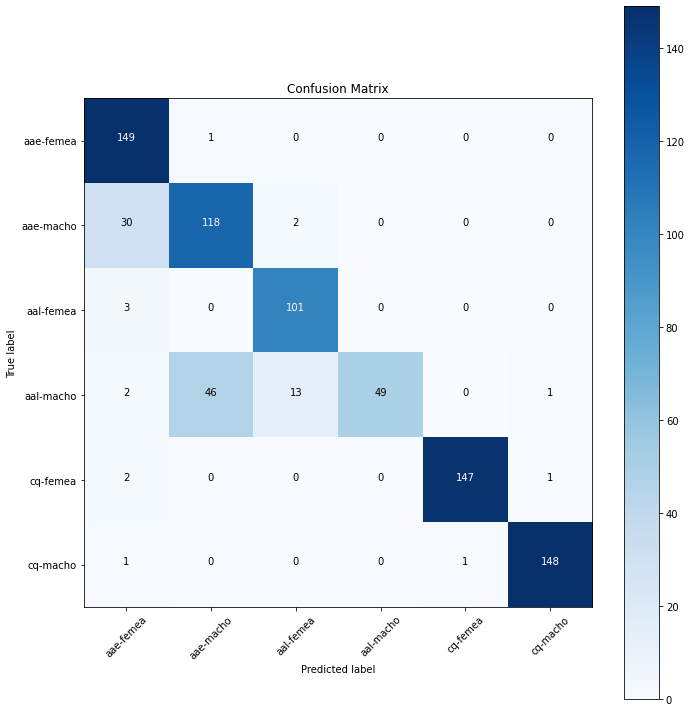

In [ ]:
cm = confusion_matrix(test_ds.classes,
                            y_pred,)

plot_confusion_matrix(cm, target_names, False, title='Confusion Matrix')

In [ ]:
predictions

array([[9.9997008e-01, 3.7906607e-09, 2.8933915e-05, 3.8214754e-10,
        9.4911371e-07, 2.0286837e-14],
       [9.9999988e-01, 8.2040913e-08, 9.0028462e-10, 6.0375392e-11,
        5.6454463e-09, 1.2196820e-13],
       [9.9996698e-01, 1.6763463e-05, 1.6252772e-05, 9.7699075e-09,
        1.5275763e-08, 2.1320306e-13],
       ...,
       [2.0803091e-06, 2.2344726e-05, 1.2835046e-07, 1.3677207e-08,
        3.3342829e-05, 9.9994206e-01],
       [1.6693394e-06, 6.4322847e-04, 1.7953269e-07, 7.7383876e-05,
        1.1571395e-06, 9.9927634e-01],
       [7.0607843e-05, 5.5849065e-05, 3.4079812e-06, 2.6037597e-07,
        4.8259896e-04, 9.9938726e-01]], dtype=float32)

## Curva ROC

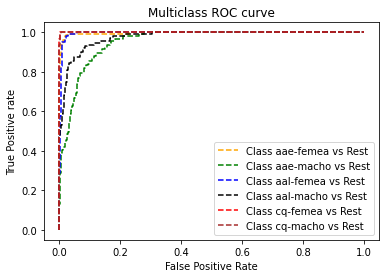

In [ ]:
#ROC CURVE
from sklearn.metrics import roc_curve



# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 6

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(test_ds.classes, predictions[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class aae-femea vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class aae-macho vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class aal-femea vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='black', label='Class aal-macho vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='red', label='Class cq-femea vs Rest')
plt.plot(fpr[5], tpr[5], linestyle='--',color='brown', label='Class cq-macho vs Rest')


plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);